In [127]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

import sys
sys.path.append('../python')
from functions import *
from models import *

import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # pick a number < 4 on ML4HEP; < 3 on Voltan 
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preparation

## Load a file and label the stream stars

In [ ]:
column_names = ["μ_δ", "μ_α", "δ", "α", "color", "mag", "lon", "lat", "μ_loncoslat", "μ_lat"]
gd1_stars = np.load('../gaia_data/gd1/gd1_stars.npy')
filename = "./gaia_data/gd1/gaiascan_l207.0_b50.2_ra148.6_dec24.2.npy"
df = pd.DataFrame(np.load(filename), columns = column_names)
is_stream, stream = FilterGD1(np.array(df), gd1_stars)

In [ ]:
plt.hist2d(df.μ_lat, df.μ_loncoslat, bins=np.linspace(-30,10,50));

In [ ]:
plt.hist2d(df.lon, df.lat, bins=100);

In [ ]:
plt.figure(dpi=100)
plt.scatter(df[is_stream].α, df[is_stream].δ)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$")
plt.title("GD1 Stars in this Patch");

## Get GD1 stars from all patches

In [ ]:
patch_list = [
 # b = 33.7 
 './gaia_data/gd1/gaiascan_l195.0_b33.7_ra128.4_dec28.8.npy',
 './gaia_data/gd1/gaiascan_l210.0_b33.7_ra132.6_dec16.9.npy',
 './gaia_data/gd1/gaiascan_l225.0_b33.7_ra138.1_dec5.7.npy', 
 # b = 41.8 
 './gaia_data/gd1/gaiascan_l187.5_b41.8_ra136.5_dec36.1.npy',
 './gaia_data/gd1/gaiascan_l202.5_b41.8_ra138.8_dec25.1.npy',
 './gaia_data/gd1/gaiascan_l217.5_b41.8_ra142.7_dec14.5.npy', 
 # b = 50.2 
 './gaia_data/gd1/gaiascan_l99.0_b50.2_ra224.7_dec60.6.npy',
 './gaia_data/gd1/gaiascan_l117.0_b50.2_ra202.4_dec66.5.npy',
 './gaia_data/gd1/gaiascan_l135.0_b50.2_ra174.3_dec65.1.npy',
 './gaia_data/gd1/gaiascan_l153.0_b50.2_ra156.2_dec57.5.npy',
 './gaia_data/gd1/gaiascan_l171.0_b50.2_ra148.6_dec47.0.npy',
 './gaia_data/gd1/gaiascan_l189.0_b50.2_ra146.9_dec35.6.npy',
 './gaia_data/gd1/gaiascan_l207.0_b50.2_ra148.6_dec24.2.npy',
 # b = 58.4 
 './gaia_data/gd1/gaiascan_l101.2_b58.4_ra212.7_dec55.2.npy',
 './gaia_data/gd1/gaiascan_l123.8_b58.4_ra192.0_dec58.7.npy',
 './gaia_data/gd1/gaiascan_l146.2_b58.4_ra171.8_dec54.7.npy',
 './gaia_data/gd1/gaiascan_l168.8_b58.4_ra160.5_dec45.5.npy',
 './gaia_data/gd1/gaiascan_l191.2_b58.4_ra156.9_dec34.1.npy',
 # b = 66.4 
 './gaia_data/gd1/gaiascan_l105.0_b66.4_ra203.7_dec49.1.npy',
 './gaia_data/gd1/gaiascan_l135.0_b66.4_ra185.4_dec50.0.npy',
 './gaia_data/gd1/gaiascan_l165.0_b66.4_ra171.4_dec43.0.npy',    
]

In [ ]:
dfs = []

for file in tqdm(patch_list):
    df = pd.DataFrame(np.load(file), columns = column_names)
    is_stream, stream = FilterGD1(np.array(df), gd1_stars)
    df["stream"] = is_stream
    df["patch_id"] = patch_list.index(file)
    dfs.append(df)

In [ ]:
df_all = pd.concat([df for df in dfs])
df_all['α'] = df_all['α'].apply(lambda x: x if x > 100 else x + 360) # wrap around plot
df_all.to_hdf("gd1_allpatches.h5", key="df")

In [ ]:
gd1_stars_in_patches = pd.concat([df[df.stream] for df in dfs])

In [ ]:
plt.figure(dpi=150)
plt.scatter(gd1_stars_in_patches.α, gd1_stars_in_patches.δ, marker='.')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$")
plt.title("GD1 Stars in All Patches");

That's a little funky, let's modify it:

In [ ]:
gd1_stars_in_patches['α_new'] = gd1_stars_in_patches['α'].apply(lambda x: x if x > 100 else x + 360)

In [ ]:
plt.figure(figsize=(12,3),dpi=150)
plt.scatter(gd1_stars_in_patches.α_new, gd1_stars_in_patches.δ, marker='.', c=gd1_stars_in_patches.μ_δ)
plt.colorbar(label=r"$\mu_\delta$")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$")
plt.title("GD1 Stream (21 patches)");

## Define a new, optimized tail patch

Load all the patches:

In [ ]:
df_all = pd.read_hdf("./gaia_data/gd1/gd1_allpatches.h5")

In [ ]:
visualize_stream(df_all)

Define a new, optimized patch for the tail & save it:

In [ ]:
# df = df_all[(df_all.α > 120) & (df_all.α < 140)] # select just the (left) tail area 
df = df_all[(df_all.α > 185) & (df_all.α < 230)] # select just the (right) tail area 
# df.α = df.α - df.α.mean()
# df.δ = df.δ - df.δ.mean()
df = df[(df.α - df.α.mean())**2 + (df.δ - df.δ.mean())**2 < 15**2]

In [ ]:
df

In [ ]:
df.to_hdf("./gaia_data/gd1_tail/gd1_tail_optimized_patch_left.h5", "df")

## Load the optimized patch & train:

In [ ]:
df = pd.read_hdf("./gaia_data/gd1_tail/gd1_tail_optimized_patch.h5", "df")

In [ ]:
visualize_stream(df)

In [ ]:
df_train = signal_sideband(df, stream="gd1_tail",
#                     Right tail patch
                    sb_min = -7, 
                    sr_min = -6, 
                    sr_max = -3.1,
                    sb_max = -3
                           
#                     sb_min = -4.5, 
#                     sr_min = -4, 
#                     sr_max = -3,
#                     sb_max = -2.5
                           
#                     sb_min = -10, 
#                     sr_min = -6, 
#                     sr_max = -1,
#                     sb_max = 1
                         
#                     # Left tail patch       
#                     sb_min = -15, 
#                     sr_min = -13.5, 
#                     sr_max = -11,
#                     sb_max = -10
                        )

Add sample weights to stream stars:

In [ ]:
stream_weight = 1

### Throughout signal & sideband regions
df_train["weight"] = np.where(df_train['stream'] == True, stream_weight, 1)

Train:

In [ ]:
df_train.weight.unique()

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
test = train(df_train,
      n_folds = 1, 
      best_of_n_loops = 1,
      layer_size = 128, 
      batch_size = 10000, 
      dropout = 0.2, 
      epochs = 2000,
      patience = 30)

## Load a pre-trained model on the tail

In [ ]:
test = pd.read_hdf("./trained_models/foundtail_size128_batch10000_epochs2000/df_test.h5")

In [ ]:
# visualize_stream(test)

In [ ]:
plot_results(test)

In [ ]:
top_stars = test.sort_values('nn_score',ascending=False)[:100]

In [ ]:
top_stars.keys()

In [ ]:
labeled_gd1 = top_stars[top_stars.stream]
unlabeled_gd1 = top_stars[top_stars.stream == False]

In [ ]:
best_unlabeled = unlabeled_gd1.sort_values('nn_score',ascending=False)[:10]

In [ ]:
plt.figure(figsize=(4,4))
plt.scatter(labeled_gd1.α, labeled_gd1.δ, label="Labeled GD1")
plt.scatter(unlabeled_gd1.α, unlabeled_gd1.δ, label="Unlabeled")
plt.legend()
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$");

In [ ]:
plt.figure(figsize=(4,4))
plt.scatter(labeled_gd1.μ_α, labeled_gd1.μ_δ, label="Labeled GD1")
plt.scatter(unlabeled_gd1.μ_α, unlabeled_gd1.μ_δ, label="Unlabeled")
plt.legend()
plt.xlabel(r"$\mu_\alpha$")
plt.ylabel(r"$\mu_\delta$");

# Run on each of the 21 GD1 patches

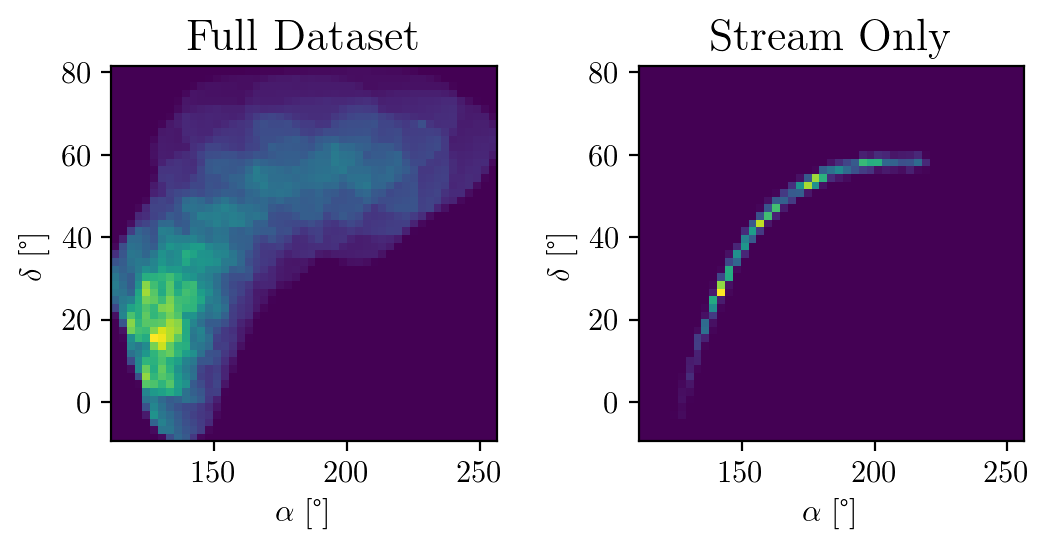

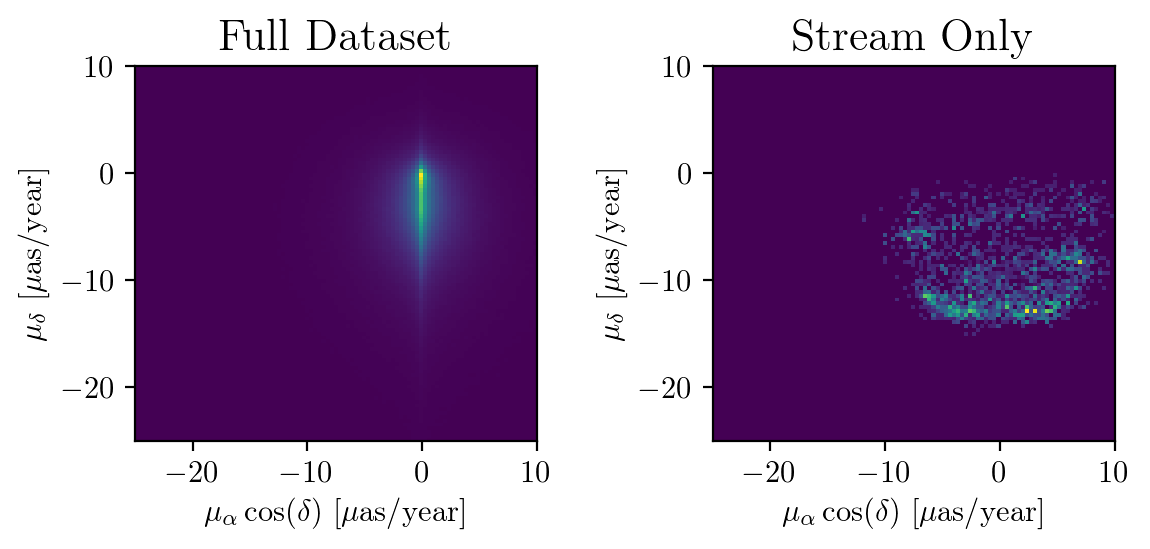

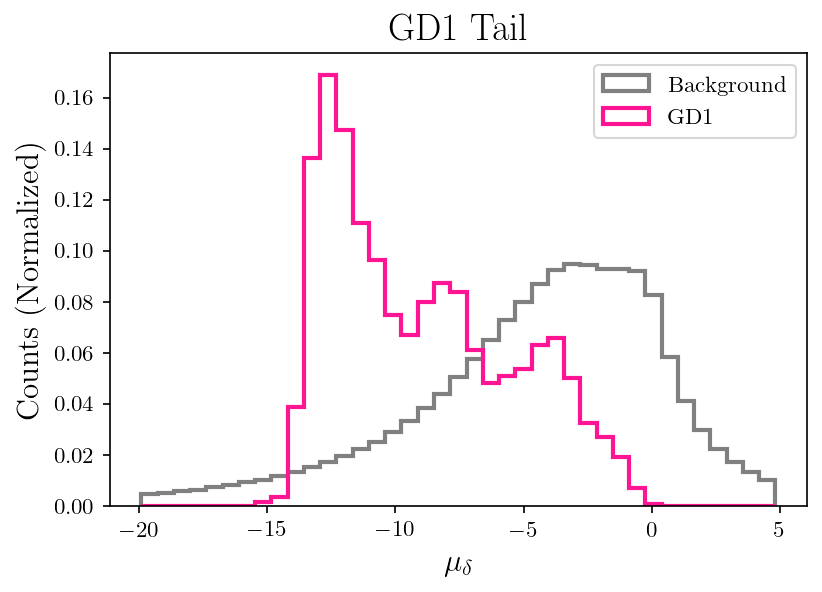

In [ ]:
df_all = pd.read_hdf("../gaia_data/gd1/gd1_allpatches.h5")
visualize_stream(df_all, save_folder="test")

In [133]:
df_all.keys()

Index(['μ_δ', 'μ_α', 'δ', 'α', 'color', 'mag', 'lon', 'lat', 'μ_loncoslat',
       'μ_lat', 'stream', 'patch_id'],
      dtype='object')

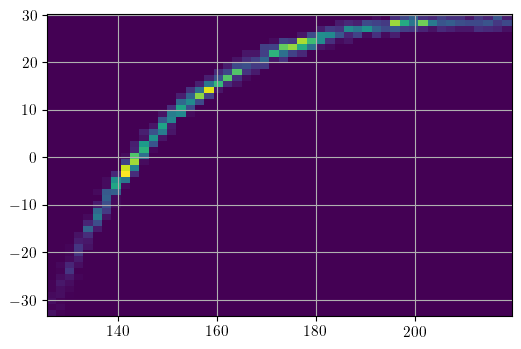

In [138]:
plt.hist2d(df_all[df_all.stream].α, df_all[df_all.stream].δ-30, bins=50)
plt.grid()

In [119]:
df_all.μ_δ.max()

88.42618560791016

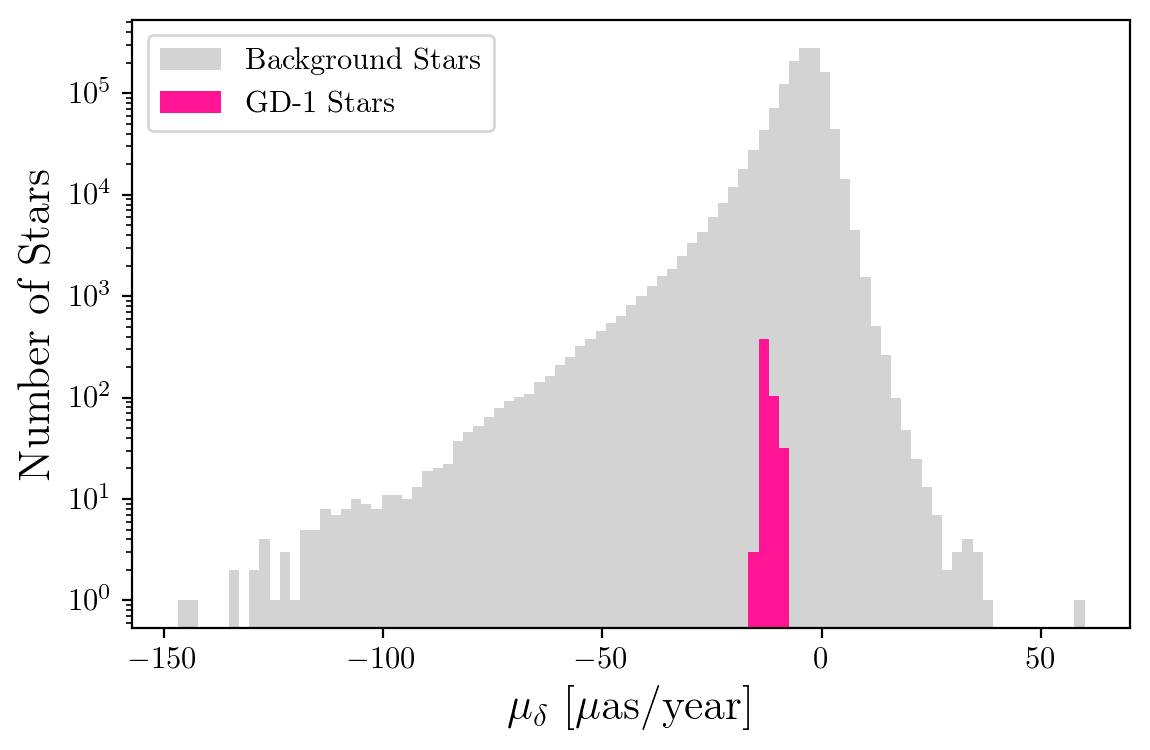

In [126]:
plt.figure(dpi=200, tight_layout=True)
bins=np.linspace(df_all.μ_δ.min(), 60, 90)
plt.hist(df_all[(df_all.stream == False) & (df_all.patch_id ==4)].μ_δ, bins=bins, color='lightgray', label="Background Stars");
plt.hist(df_all[(df_all.stream == True) & (df_all.patch_id ==4)].μ_δ, bins=bins, color='deeppink', label="GD-1 Stars");
plt.yscale('log')
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]", fontsize=16);
plt.ylabel("Number of Stars", fontsize=16);
plt.legend(loc="upper left");
plt.savefig("../plots/localized_stream.pdf");

In [72]:
def plot_coords(df):
    fig, axs = plt.subplots(nrows=2, ncols=3, dpi=150, figsize=(10,7), tight_layout=True)
    
    bins_α=np.linspace(df.α.min(),df.α.max(),100)
    bins_δ=np.linspace(df.δ.min(),df.δ.max(),100)
    
    ax = axs[0,0]
    ax.hist2d(df.α,df.δ, bins=[bins_α,bins_δ])
    ax.set_xlabel(r"$\alpha$ [\textdegree]", fontsize=11)
    ax.set_ylabel(r"$\delta$ [\textdegree]", fontsize=11);
    ax.set_title("Full Dataset", fontsize=16)
    
    ax = axs[1,0]
    ax.hist2d(df[df.stream == True].α,df[df.stream == True].δ, bins=[bins_α,bins_δ])
    ax.set_xlabel(r"$\alpha$ [\textdegree]", fontsize=11)
    ax.set_ylabel(r"$\delta$ [\textdegree]", fontsize=11);
    ax.set_title("Stream Only", fontsize=16);
    
    bins = np.linspace(-25,10,100)
    ax = axs[0,1]
    ax.hist2d(df.μ_α*np.cos(df.δ),df.μ_δ, bins=[bins,bins])
    ax.set_xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]", fontsize=11)
    ax.set_ylabel(r"$\mu_\delta$ [$\mu$as/year]", fontsize=11);
    ax.set_title("Full Dataset", fontsize=16)
    
    ax = axs[1,1]
    ax.hist2d(df[df.stream == True].μ_α*np.cos(df[df.stream == True].δ), df[df.stream == True].μ_δ, bins=[bins,bins])
    ax.set_xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]", fontsize=11)
    ax.set_ylabel(r"$\mu_\delta$ [$\mu$as/year]", fontsize=11);
    ax.set_title("Stream Only", fontsize=16);
    
    bins_color=np.linspace(df.color.min(),df.color.max(),100)
    bins_mag=np.linspace(df.mag.min(),df.mag.max(),100)
    
    ax = axs[0,2]
    ax.hist2d(df.color,df.mag, bins=[bins_color,bins_mag])
    ax.set_ylim(ax.get_ylim()[::-1]) # reverse y axis to match Via Machinae plot
    ax.set_xlabel(r"$b-r$", fontsize=11)
    ax.set_ylabel(r"$g$", fontsize=11);
    ax.set_title("Full Dataset", fontsize=16)
    
    ax = axs[1,2]
    ax.hist2d(df[df.stream == True].color,df[df.stream == True].mag, bins=[bins_color,bins_mag])
    ax.set_ylim(ax.get_ylim()[::-1]) # reverse y axis to match Via Machinae plot
    ax.set_xlabel(r"$b-r$", fontsize=11)
    ax.set_ylabel(r"$g$", fontsize=11);
    ax.set_title("Stream Only", fontsize=16);
    
#     plt.savefig("input_variables.pdf")

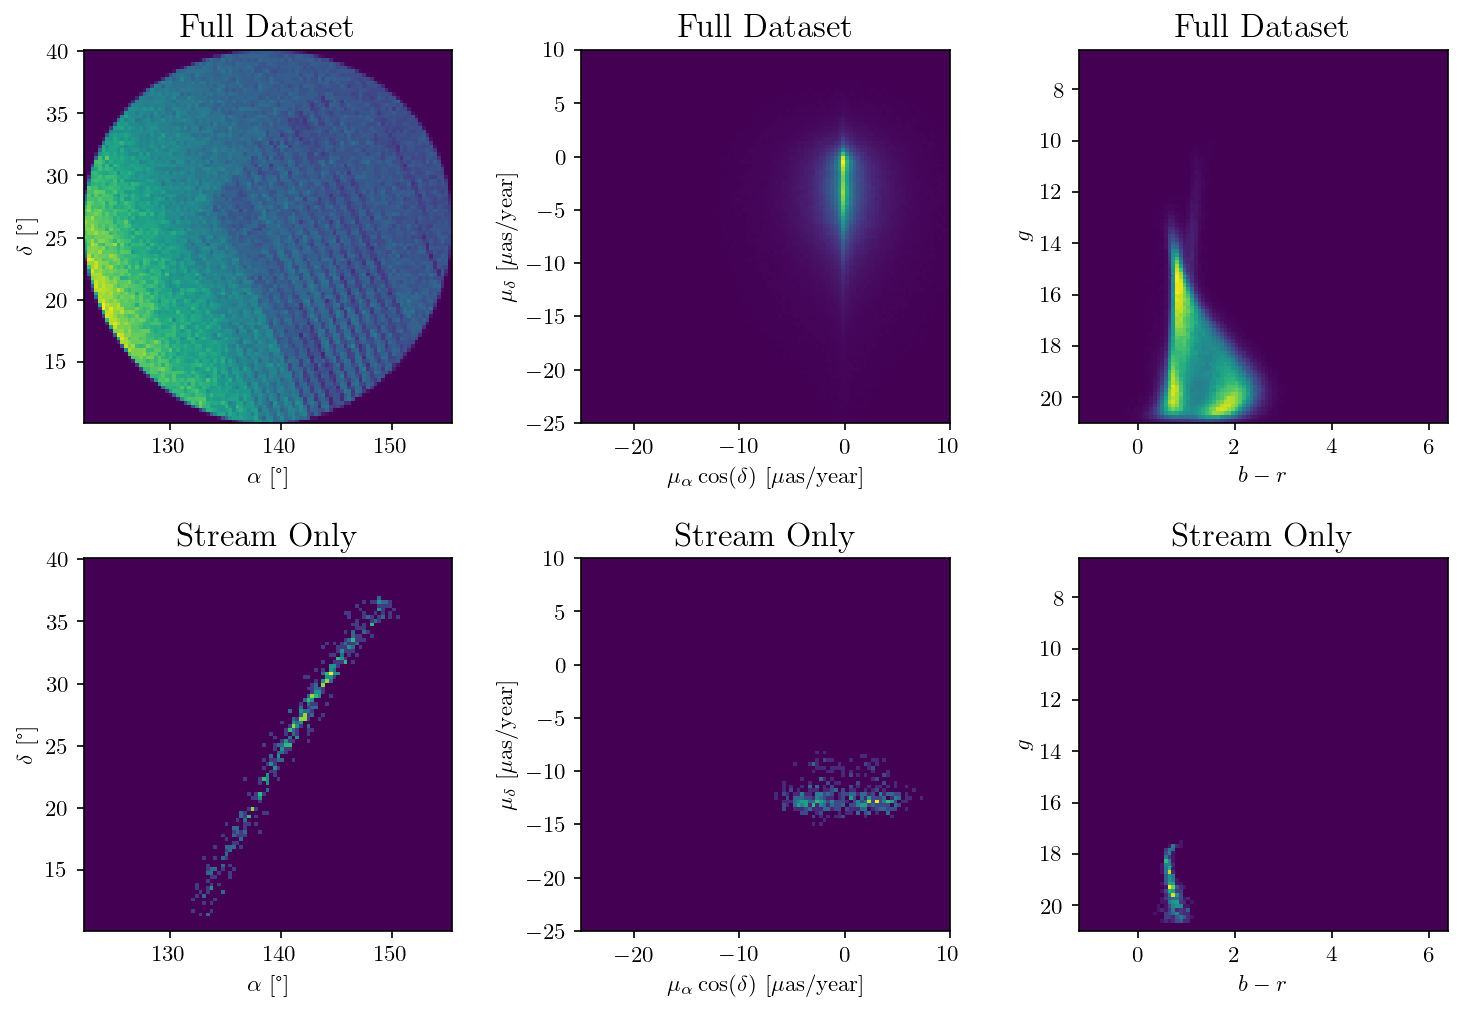

In [73]:
plot_coords(df_all[df_all.patch_id == 4])

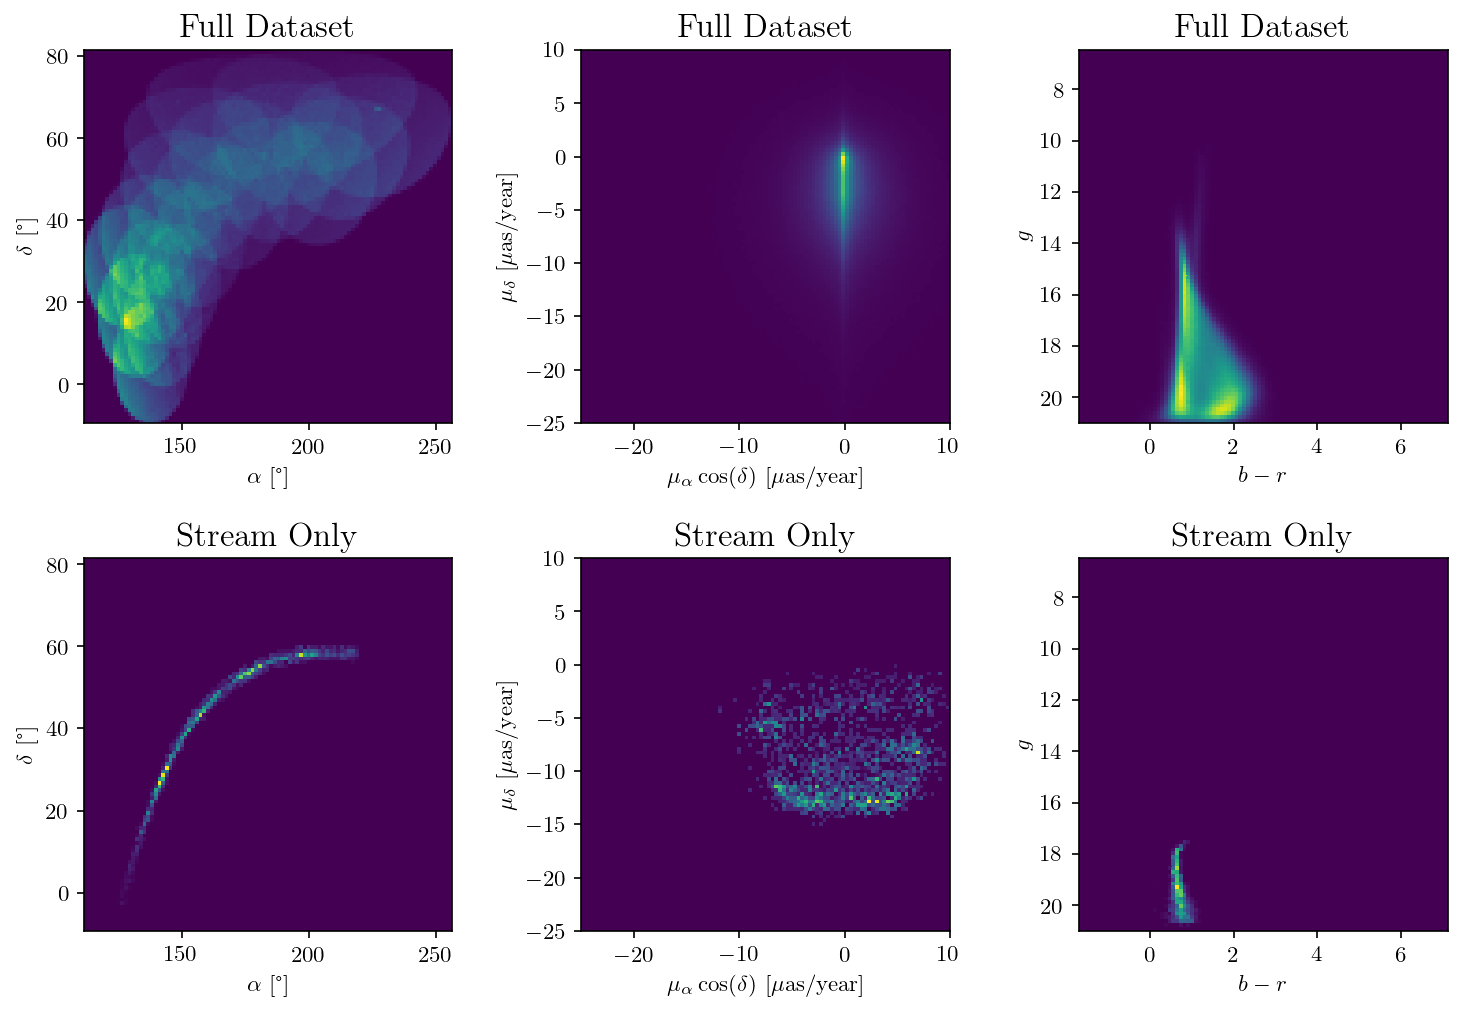

In [74]:
plot_coords(df_all)

In [60]:
df_all_noduplicates = df_all.drop_duplicates(subset=['δ'])

In [61]:
len(df_all_noduplicates)

8040823

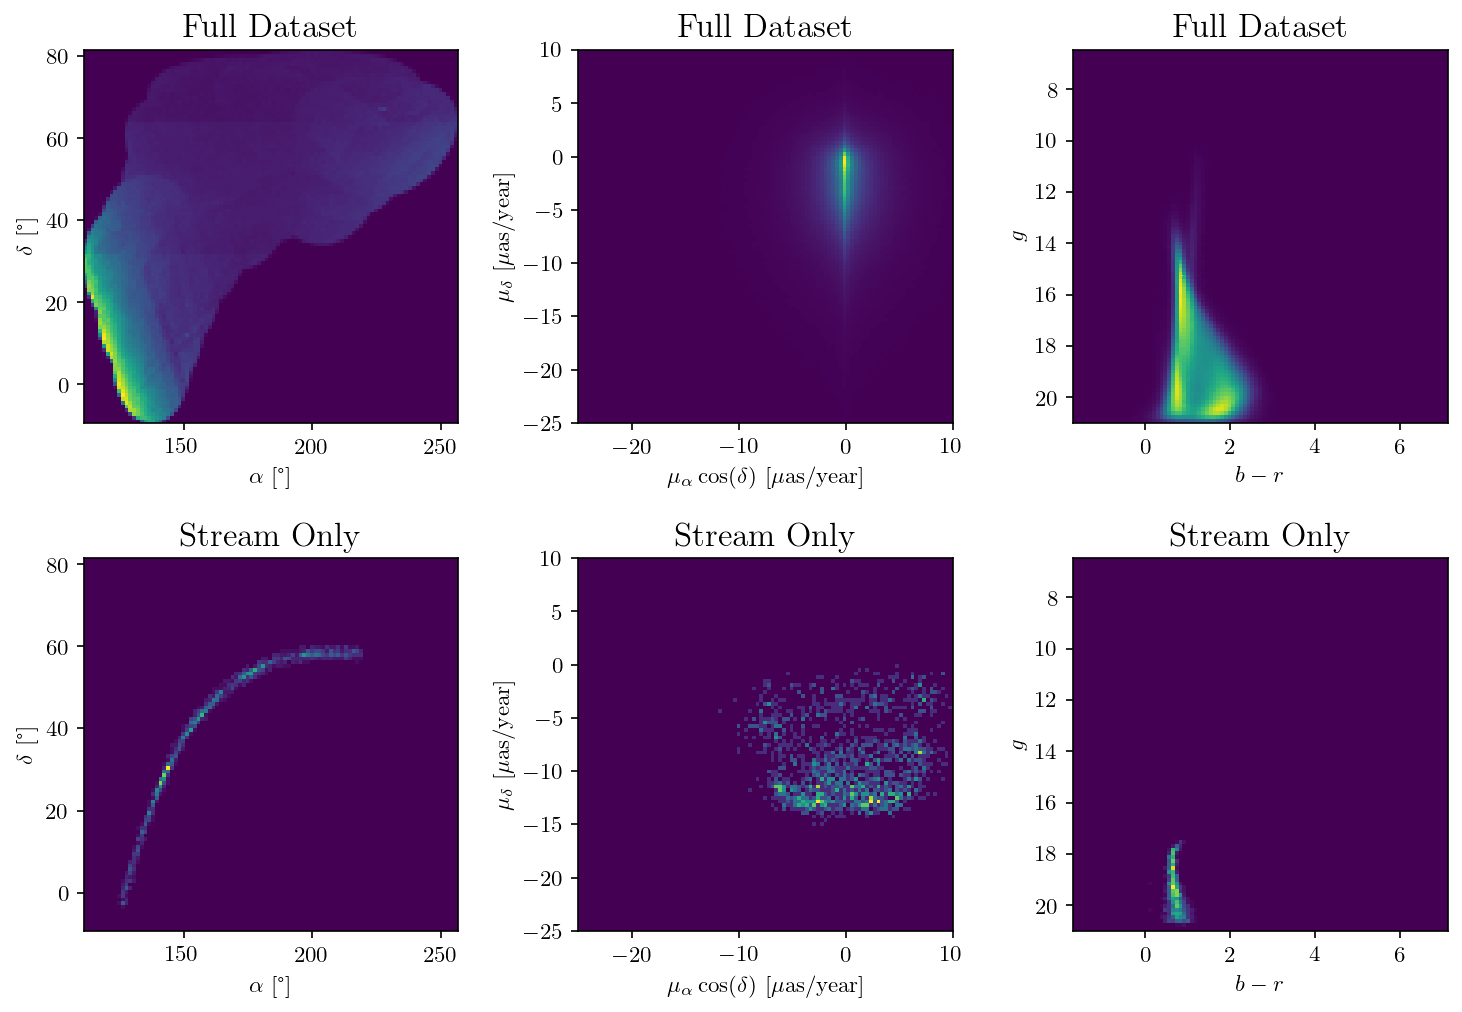

In [62]:
plot_coords(df_all_noduplicates)

In [ ]:
target_stream = []
top_100_stars = []

n_patches = 10
alphas = np.linspace(df_all[df_all.stream].α.min(), df_all[df_all.stream].α.max(), n_patches)
deltas = np.array([df_all[(df_all.stream & (np.abs(df_all.α - alpha) < 5))].δ.mean() for alpha in alphas])
limits = pd.DataFrame(zip(np.arange(len(alphas)),alphas,deltas), columns=["patch_id","α_center", "δ_center"])

for patch_id in tqdm(limits.patch_id.unique()):
    α_min = limits.iloc[patch_id]["α_center"]-10
    α_max = limits.iloc[patch_id]["α_center"]+10
    δ_min = limits.iloc[patch_id]["δ_center"]-10
    δ_max = limits.iloc[patch_id]["δ_center"]+10
    df = (df_all[(α_min < df_all.α) & (df_all.α < α_max) & 
                 (δ_min < df_all.δ) & (df_all.δ < δ_max)])
    if np.sum(df.stream)/len(df) < 0.0001: # skip patches with hardly any stream stars
        continue
    else:
#         try: 
#             plt.figure()
#             plt.scatter(df[df.stream].α, df[df.stream].δ, alpha=0.1)
#             visualize_stream(df)
#         except: 
#             continue
        target_stream.append(df[df.stream])                
        df_train = signal_sideband(df, save_folder="test/patches/patch{}".format(str(patch_id)),
                        sb_min = df[df.stream].μ_δ.min(),
                        sr_min = df[df.stream].μ_δ.min()+1,
                        sr_max = df[df.stream].μ_δ.max()-1,
                        sb_max = df[df.stream].μ_δ.max()
                        )
        tf.keras.backend.clear_session()
        test = train(df_train, 
          n_folds = 1, 
          best_of_n_loops = 1,
          layer_size = 128, 
          batch_size = 10000, 
          dropout = 0.2, 
          epochs = 1000, 
          patience = 30,
          save_folder="test/patches/patch{}".format(str(patch_id)),)
        top_100_stars.append(test.sort_values('nn_score',ascending=False)[:100])

Try with multiprocessing:

In [ ]:
from multiprocessing import Pool

n_patches = 2
alphas = np.linspace(df_all[df_all.stream].α.min(), df_all[df_all.stream].α.max(), n_patches)
deltas = np.array([df_all[(df_all.stream & (np.abs(df_all.α - alpha) < 5))].δ.mean() for alpha in alphas])
limits = pd.DataFrame(zip(np.arange(len(alphas)),alphas,deltas), columns=["patch_id","α_center", "δ_center"])

def my_func(patch_id):
    α_min = limits.iloc[patch_id]["α_center"]-10
    α_max = limits.iloc[patch_id]["α_center"]+10
    δ_min = limits.iloc[patch_id]["δ_center"]-10
    δ_max = limits.iloc[patch_id]["δ_center"]+10
    df = (df_all[(α_min < df_all.α) & (df_all.α < α_max) & 
                 (δ_min < df_all.δ) & (df_all.δ < δ_max)])
    if np.sum(df.stream)/len(df) > 0.0001: # skip patches with hardly any stream stars
        df_train = signal_sideband(df, save_folder="test/patches/patch{}".format(str(patch_id)),
                        sb_min = df[df.stream].μ_δ.min(),
                        sr_min = df[df.stream].μ_δ.min()+1,
                        sr_max = df[df.stream].μ_δ.max()-1,
                        sb_max = df[df.stream].μ_δ.max(), 
                        verbose=False,
                        )
        tf.keras.backend.clear_session()
        test = train(df_train, 
          n_folds = 1, 
          best_of_n_loops = 1,
          layer_size = 128, 
          batch_size = 10000, 
          dropout = 0.2, 
          epochs = 2, 
          patience = 30,
          l2_reg = 0,
          save_folder="test/patches/patch{}".format(str(patch_id)),
          verbose=False,)
        top_100_stars = test.sort_values('nn_score',ascending=False)[:100]
        
    # return results for the record as pd.Series
    print("Finished Patch #{}".format(str(patch_id)))
    return test

pool = Pool(processes=2)
results = pool.map(my_func, limits.patch_id.unique())
pool.close()
pool.join()

In [ ]:
all_gd1_stars = []
cwola_stars = []

for test in results:
    n_top_stars = np.min([len(test[test.stream]),100])
    patch_top_stars = test.sort_values('nn_score',ascending=False)[:n_top_stars]
    all_gd1_stars.append(test[test.stream])
    cwola_stars.append(patch_top_stars)
    
all_gd1_stars = pd.concat([df for df in all_gd1_stars])
cwola_stars = pd.concat([df for df in cwola_stars])

plt.figure(dpi=200, figsize=(12,4))
plt.scatter(all_gd1_stars.α, all_gd1_stars.δ, marker='.', s=2, 
            color="lightgray", label="GD1")
plt.scatter(cwola_stars[cwola_stars.stream == False].α, cwola_stars[cwola_stars.stream == False].δ, marker='.', s=2, 
            color="darkorange", label="CWoLa (Non-Match)")
plt.scatter(cwola_stars[cwola_stars.stream].α, cwola_stars[cwola_stars.stream].δ, marker='.', s=2, 
            color="crimson", label="CWoLa (Match)")
plt.legend()
plt.xlabel(r"$\alpha$ [\textdegree]");
plt.xlim(120,220);

# Remake Via Machinae plot from test dataframes saved during the training

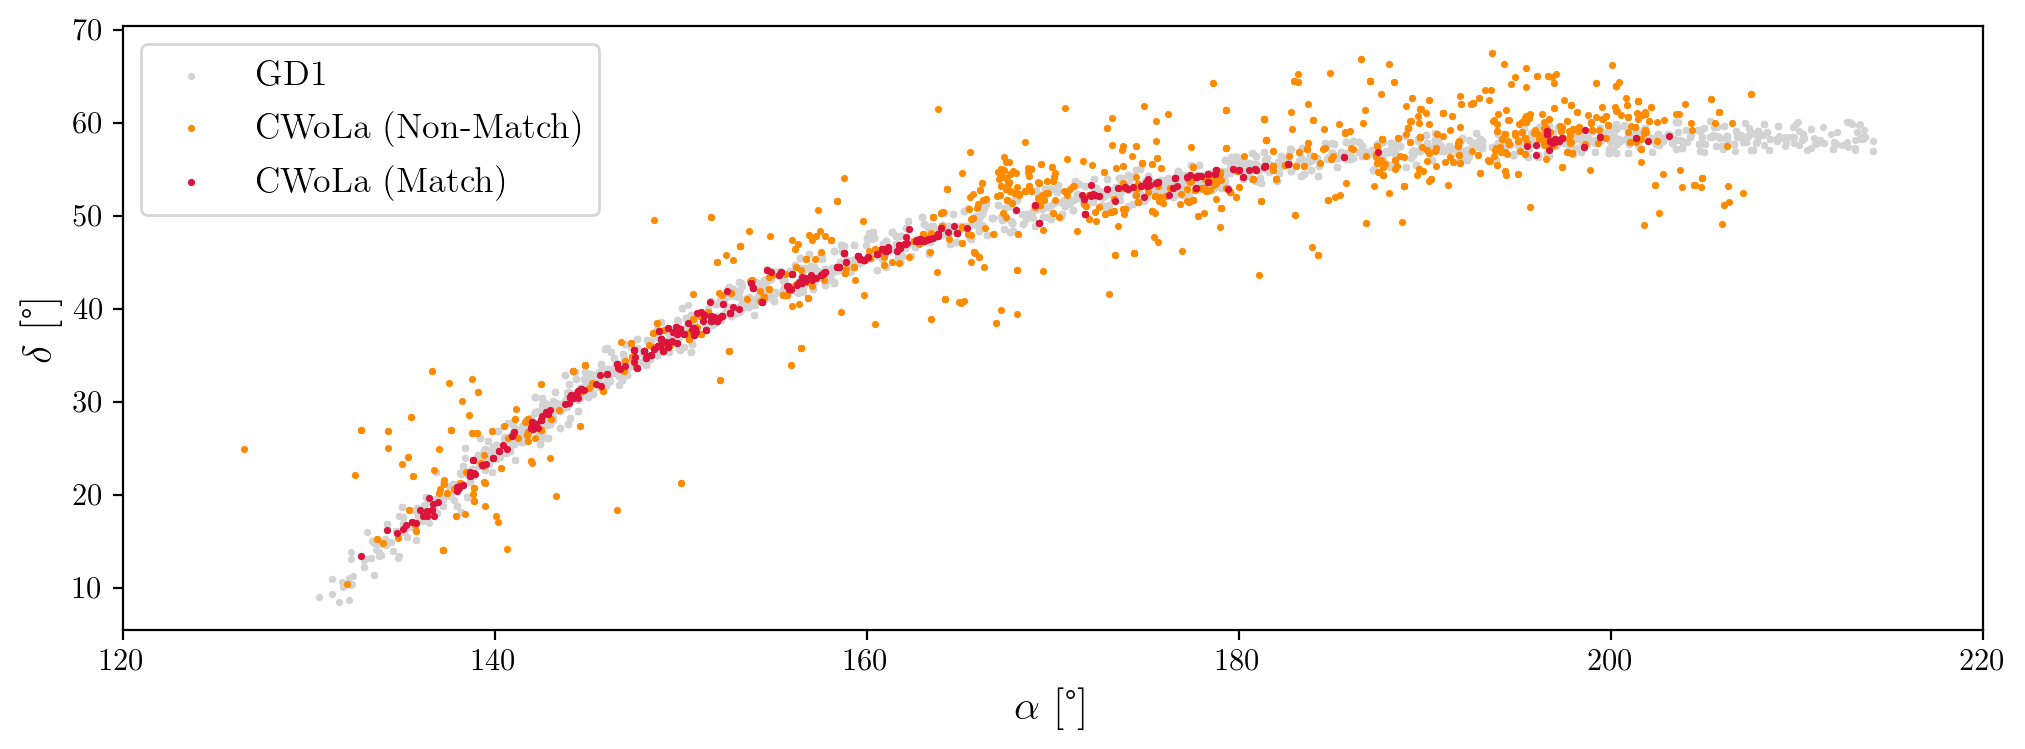

In [3]:
all_gd1_stars = []
cwola_stars = []

files = sorted(glob("../trained_models/aps_50_patches_nfolds1/patches/patch*/df_test.h5"))

for file in files[5:-8]:
    test = pd.read_hdf(file)
    n_top_stars = np.min([len(test[test.stream]),50])
    patch_top_stars = test.sort_values('nn_score',ascending=False)[:n_top_stars]
    all_gd1_stars.append(test[test.stream])
    cwola_stars.append(patch_top_stars)
    
all_gd1_stars = pd.concat([df for df in all_gd1_stars])
cwola_stars = pd.concat([df for df in cwola_stars])

plt.figure(dpi=200, figsize=(12,4))
plt.scatter(all_gd1_stars.α, all_gd1_stars.δ, marker='.', s=10, 
            color="lightgray", label="GD1")
plt.scatter(cwola_stars[cwola_stars.stream == False].α, cwola_stars[cwola_stars.stream == False].δ, marker='.', s=10, 
            color="darkorange", label="CWoLa (Non-Match)")
plt.scatter(cwola_stars[cwola_stars.stream].α, cwola_stars[cwola_stars.stream].δ, marker='.', s=10, 
            color="crimson", label="CWoLa (Match)")
plt.legend(fontsize=13)
plt.xlabel(r"$\alpha$ [\textdegree]");
plt.ylabel(r"$\delta$ [\textdegree]");
plt.xlim(120,220);
plt.savefig("via_machinae_aps_50patches_top50.png");

## Add promising stars

In [4]:
labeled = cwola_stars[cwola_stars.stream]
unlabeled = cwola_stars[cwola_stars.stream == False]

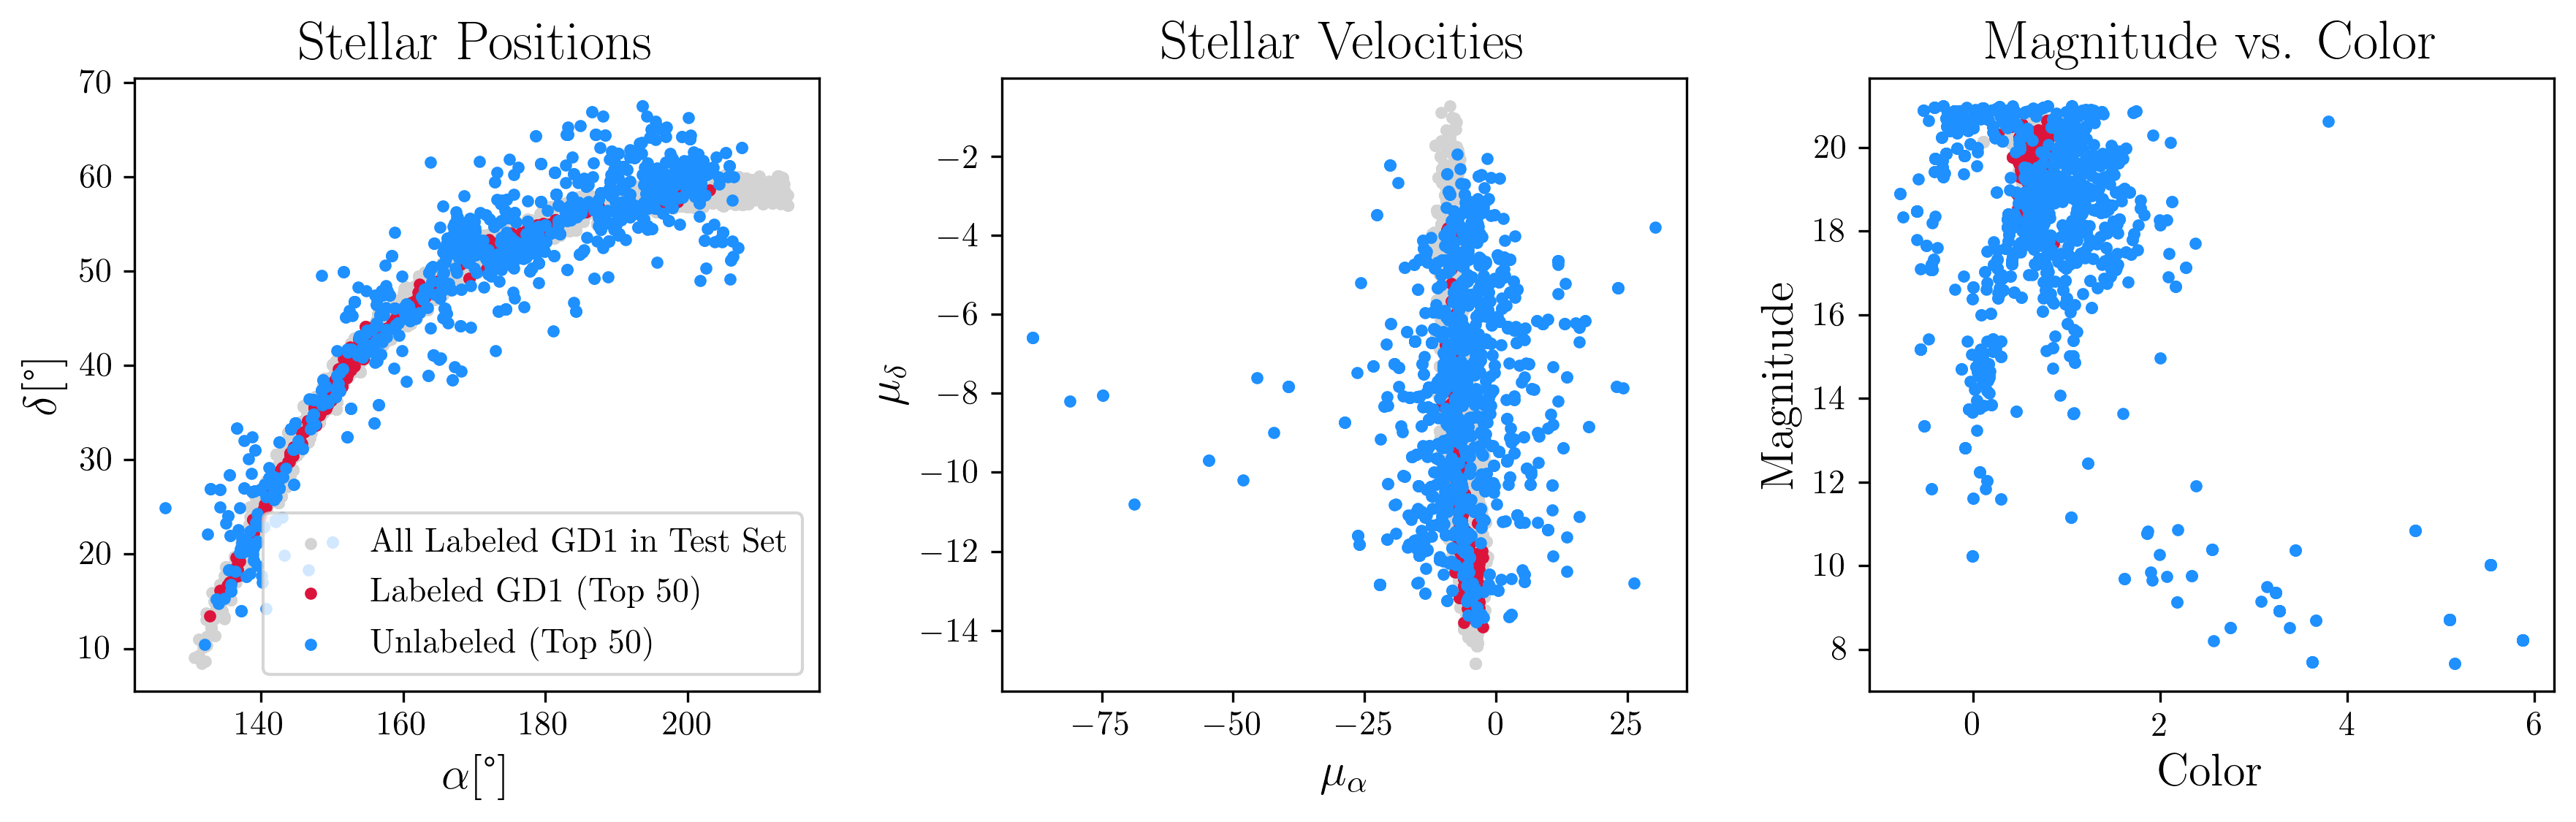

In [5]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(12,4), dpi=300, tight_layout=True)

ax = axs[0]
ax.set_title("Stellar Positions")
ax.scatter(all_gd1_stars.α, all_gd1_stars.δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.α, labeled.δ, marker='.', color="crimson",label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(unlabeled.α, unlabeled.δ, marker='.', color="dodgerblue", label="Unlabeled (Top {})".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.legend()
ax.set_xlabel(r"$\alpha$[\textdegree]")
ax.set_ylabel(r"$\delta$[\textdegree]");

ax = axs[1]
ax.set_title("Stellar Velocities")
ax.scatter(all_gd1_stars.μ_α, all_gd1_stars.μ_δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.μ_α, labeled.μ_δ, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(unlabeled.μ_α, unlabeled.μ_δ, marker='.', color="dodgerblue", label="CWoLa Top {} (Unlabeled)".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.set_xlabel(r"$\mu_{\alpha}$")
ax.set_ylabel(r"$\mu_{\delta}$");

ax = axs[2]
ax.set_title("Magnitude vs. Color")
ax.scatter(all_gd1_stars.color, all_gd1_stars.mag, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.color, labeled.mag, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(unlabeled.color, unlabeled.mag, marker='.', color="dodgerblue", label="CWoLa Top {} (Unlabeled)".format(n_top_stars))
ax.set_xlabel(r"Color")
ax.set_ylabel(r"Magnitude");
# plt.savefig("../plots/mislabeled_triptych.png")

Identify promising unlabeled stars...

/tmp/ipykernel_15860/1870732027.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled['5d_distance'] = distances


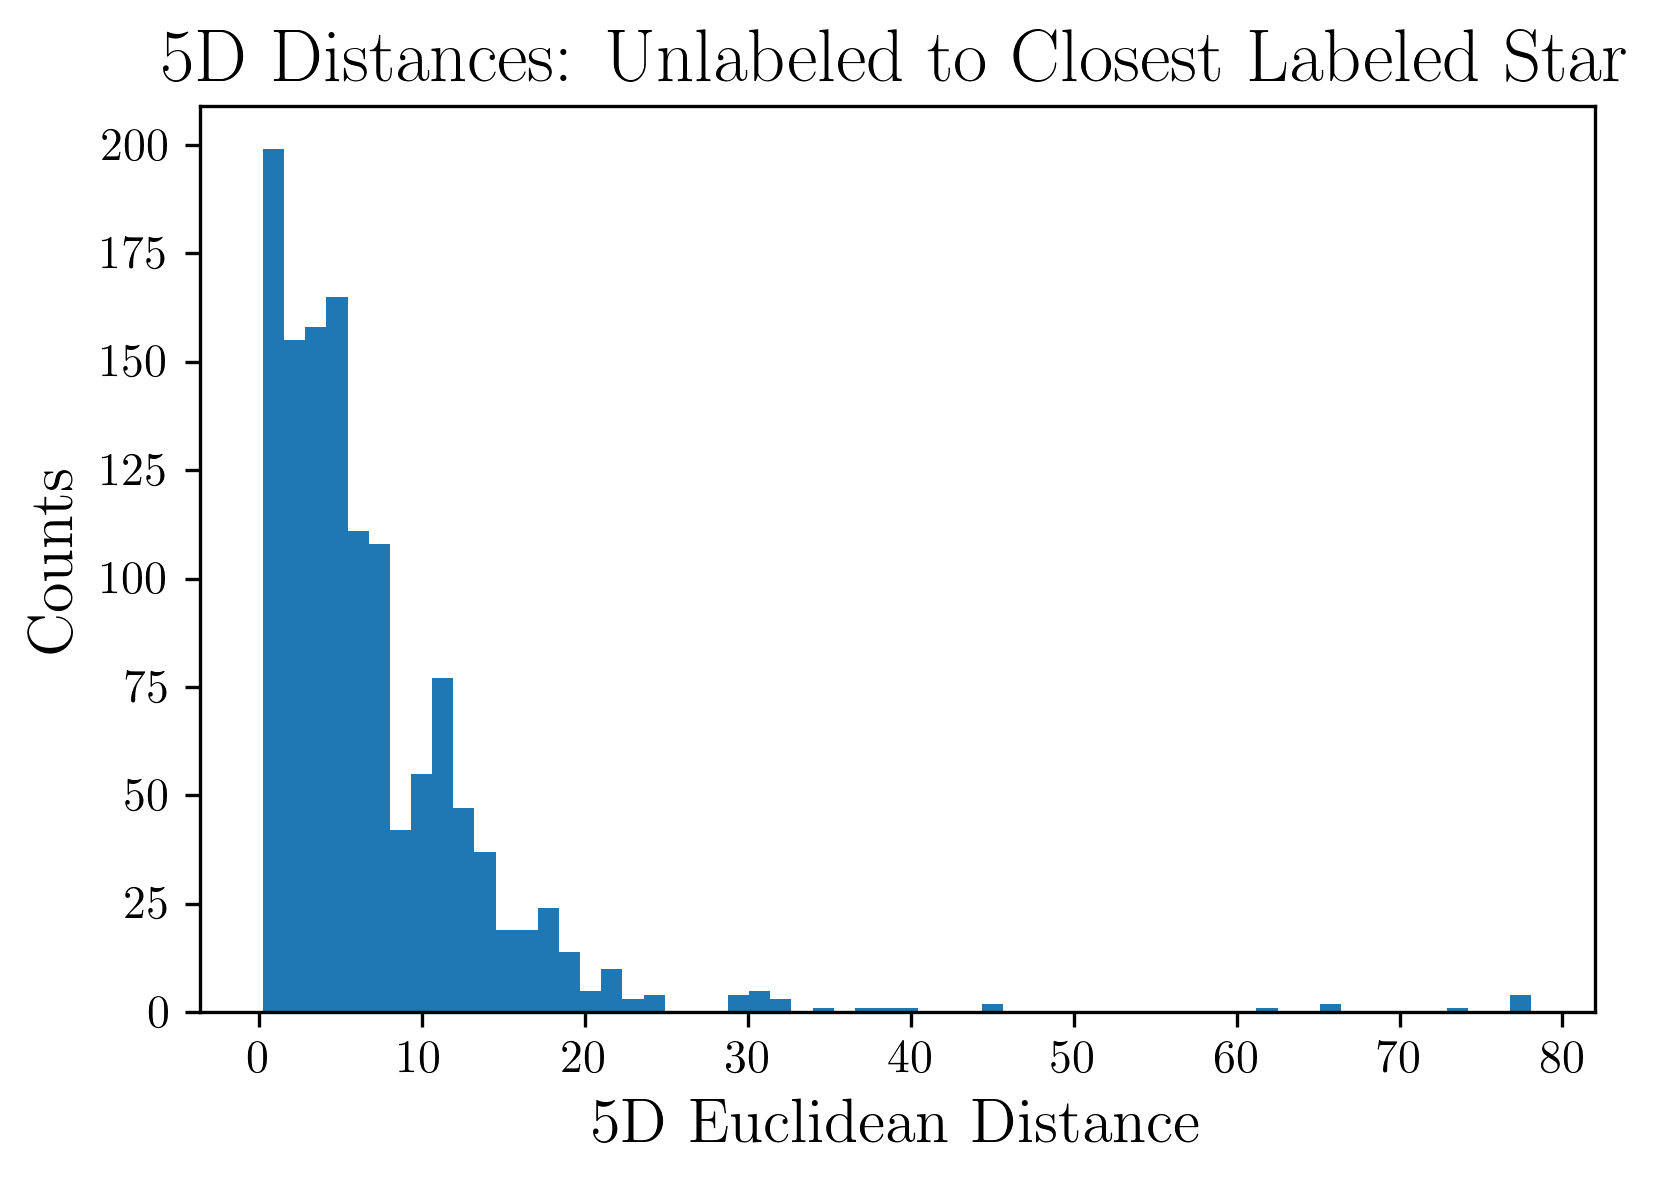

In [6]:
from scipy.spatial import distance_matrix
cols = ["μ_α", "δ", "α", "color", "mag"]
dists = distance_matrix(labeled[cols].to_numpy(), unlabeled[cols].to_numpy())
closest_labeled = labeled.iloc[dists.argmin(axis=0)]
deltas = unlabeled[cols].to_numpy()-closest_labeled[cols].to_numpy()
distances = np.sqrt(np.sum(deltas**2, axis=1))
unlabeled['5d_distance'] = distances

plt.figure(dpi=300)
plt.hist(unlabeled["5d_distance"], bins=60)
plt.title("5D Distances: Unlabeled to Closest Labeled Star");
plt.ylabel("Counts")
plt.xlabel("5D Euclidean Distance");
# plt.savefig("../plots/5d_distance.png")

In [7]:
# promising = unlabeled[(unlabeled['5d_distance'] < 1)] # restrict by a specific distance
promising = unlabeled[(unlabeled['5d_distance'] < unlabeled['5d_distance'].quantile(0.1))] # restrict to the top x%

In [8]:
len(promising)

128

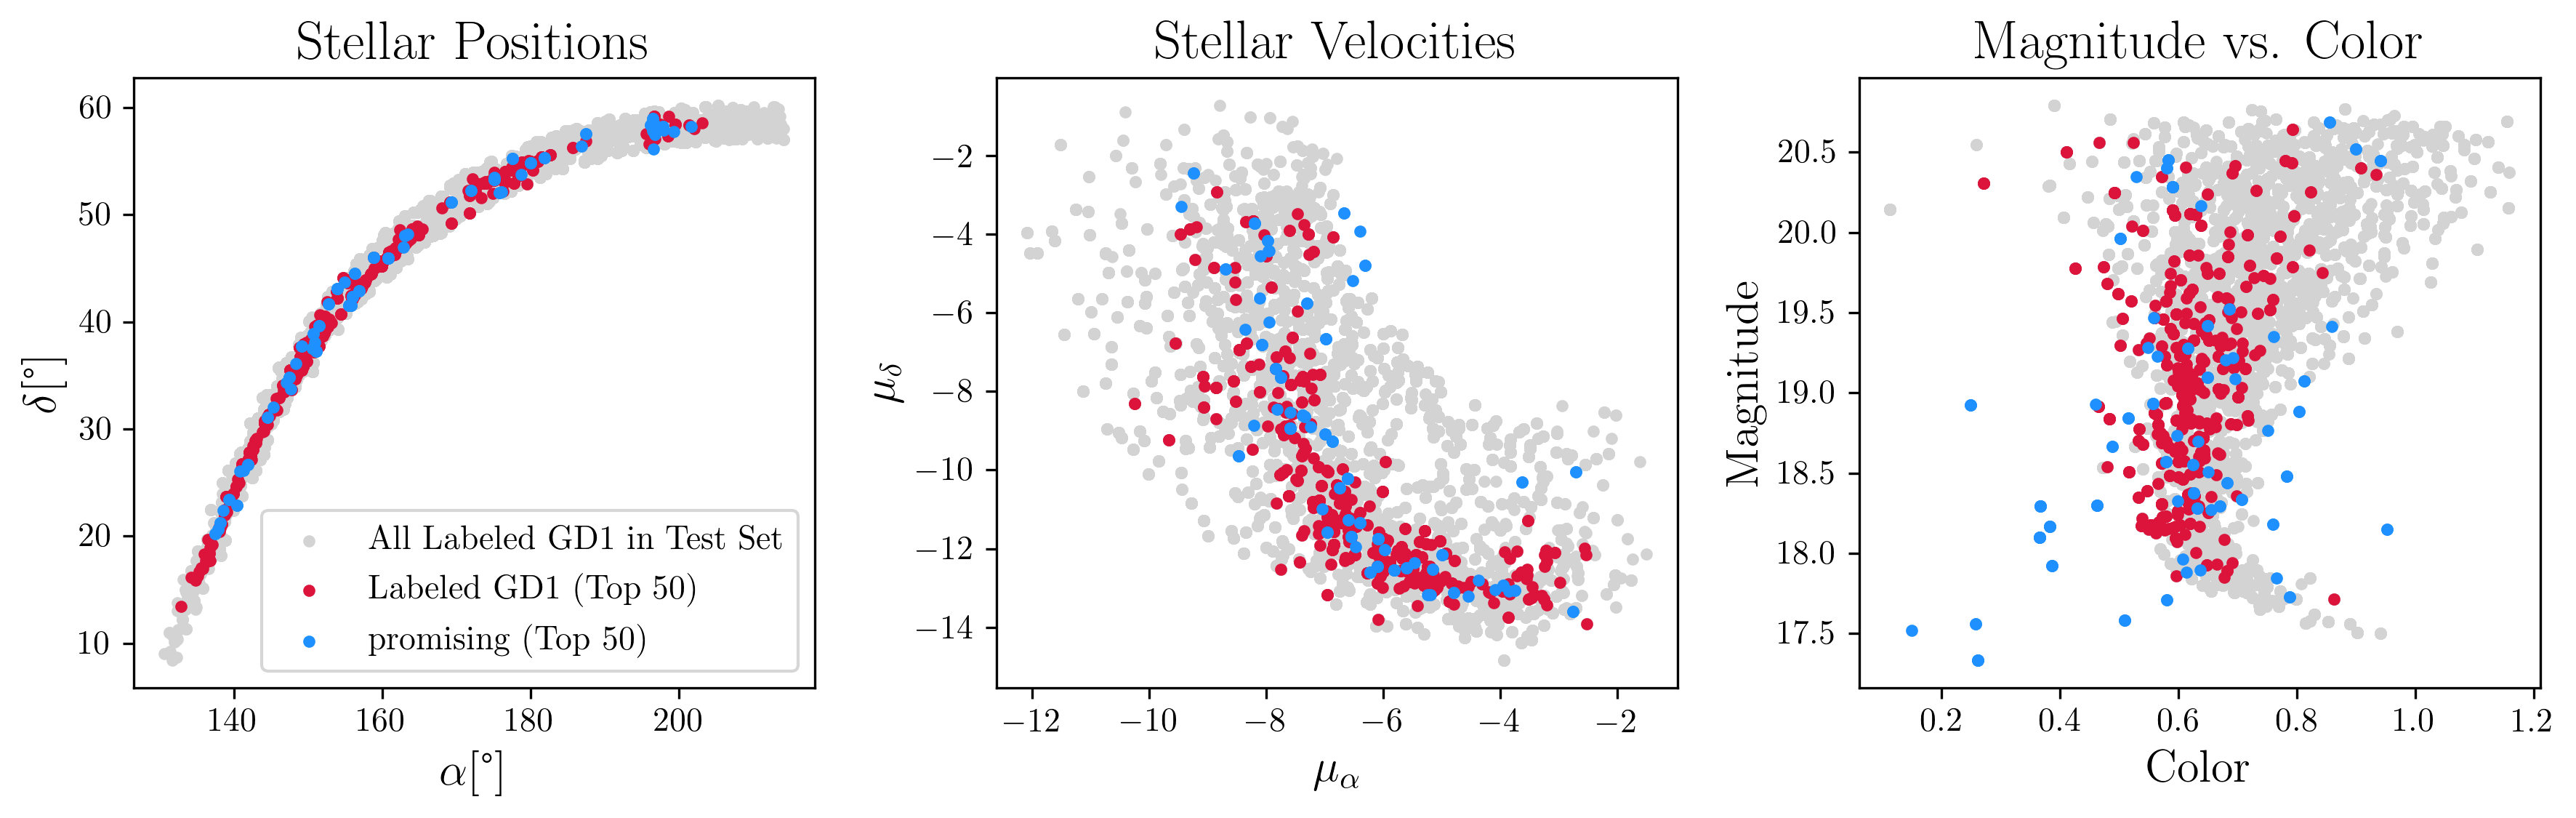

In [9]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(12,4), dpi=300, tight_layout=True)

ax = axs[0]
ax.set_title("Stellar Positions")
ax.scatter(all_gd1_stars.α, all_gd1_stars.δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.α, labeled.δ, marker='.', color="crimson",label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(promising.α, promising.δ, marker='.', color="dodgerblue", label="promising (Top {})".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.legend()
ax.set_xlabel(r"$\alpha$[\textdegree]")
ax.set_ylabel(r"$\delta$[\textdegree]");

ax = axs[1]
ax.set_title("Stellar Velocities")
ax.scatter(all_gd1_stars.μ_α, all_gd1_stars.μ_δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.μ_α, labeled.μ_δ, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(promising.μ_α, promising.μ_δ, marker='.', color="dodgerblue", label="CWoLa Top {} (promising)".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.set_xlabel(r"$\mu_{\alpha}$")
ax.set_ylabel(r"$\mu_{\delta}$");

ax = axs[2]
ax.set_title("Magnitude vs. Color")
ax.scatter(all_gd1_stars.color, all_gd1_stars.mag, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.color, labeled.mag, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(promising.color, promising.mag, marker='.', color="dodgerblue", label="CWoLa Top {} (promising)".format(n_top_stars))
ax.set_xlabel(r"Color")
ax.set_ylabel(r"Magnitude");
# plt.savefig("../plots/mislabeled_triptych.png")

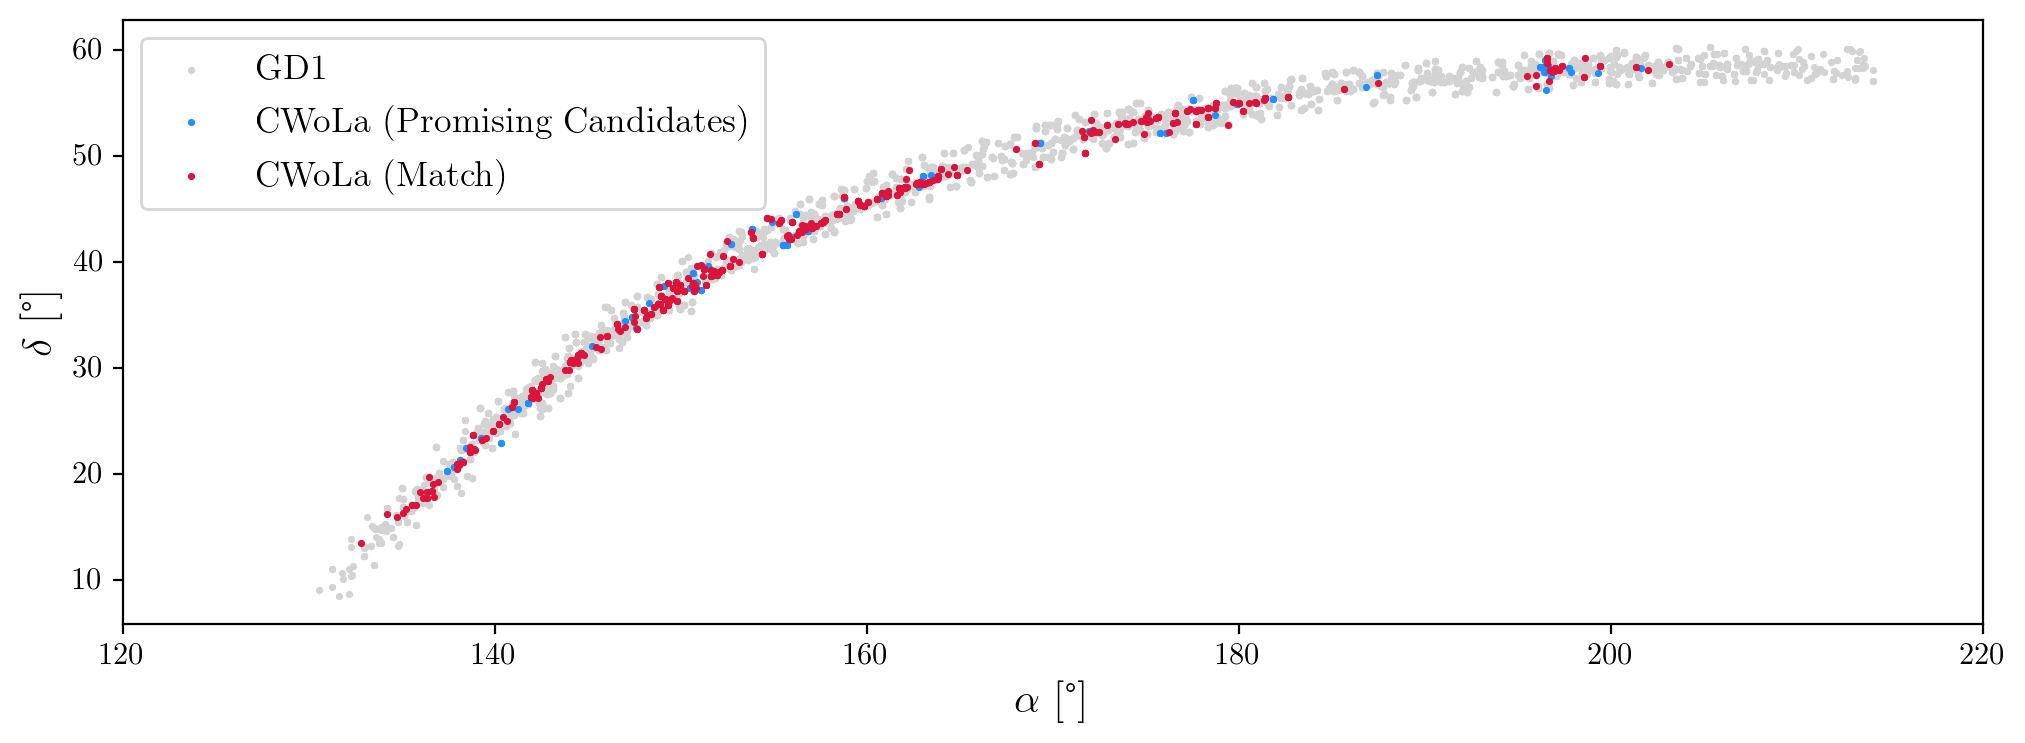

In [11]:
plt.figure(dpi=200, figsize=(12,4))
plt.scatter(all_gd1_stars.α, all_gd1_stars.δ, marker='.', s=10, 
            color="lightgray", label="GD1")
plt.scatter(promising.α, promising.δ, marker='.', s=10, 
            color="dodgerblue", label="CWoLa (Promising Candidates)")
plt.scatter(cwola_stars[cwola_stars.stream].α, cwola_stars[cwola_stars.stream].δ, marker='.', s=10, 
            color="crimson", label="CWoLa (Match)")
plt.legend(fontsize=13)
plt.xlabel(r"$\alpha$ [\textdegree]");
plt.ylabel(r"$\delta$ [\textdegree]");
plt.xlim(120,220);
# plt.savefig("via_machinae_aps_50patches_top50.png");

## scratch

In [ ]:
import pandas as pd
from random import randrange
from multiprocessing import Pool

#Trivial example function 
def my_func(record):
    sub_df = df.loc[df['Record'] == record]
    sub_df['Result'] = randrange(0,100)
    # return results for the record as pd.Series
    return sub_df['Result']  

In [ ]:
d = {'Record': ['A', 'A', 'B', 'B'], 'Values': [100, 200, 50, 70]}
df = pd.DataFrame(d)
all_records = df['Record'].unique()

In [ ]:
pool = Pool(processes=2)
results = pool.map(my_func, all_records)
pool.close()
pool.join()

# concatenate results into a single pd.Series
results = pd.concat(results)

# join results with original df
joined_df = df.join(results)

print(joined_df)

In [ ]:
id = 20
α_min = df_all[df_all.patch_id == id].α.min()
α_max = df_all[df_all.patch_id == id].α.max()
δ_min = df_all[df_all.patch_id == id].δ.min()
δ_max = df_all[df_all.patch_id == id].δ.max()

visualize_stream(df_all[(α_min < df_all.α) & (df_all.α < α_max) & 
                        (δ_min < df_all.δ) & (df_all.δ < δ_max)])

Hand-pick limits for each patch:

In [ ]:
limits = pd.DataFrame([
                  [0, -15, -13.5, -11, -10],
                  [1, -14, -13, -12, -11],
                  [2, -14, -13, -11.5, -10],
                  [3, -14, -13, -11, -10],
                  [4, -15, -14, -12, -11],
                  [5, -15, -14, -12, -11],
                  [6, -5, -4, -2.5, 2],
                  [7, -10, -9.5, -8, -7],
                  [8, -9, -8, -7, -6],
                  [9, -9, -8, -7, -6],
                  [10, -12.5, -12, -11, -10],
                  [11, -14, -13, -11, -10],
                  [12, -14, -13, -12, -11],
                  [13, -6, -5, -4, -2],
                  [14, -9, -8, -7, -6],
                  [15, -9, -8, -7, -6],
                  [16, -14, -13, -11, -10],
                  [17, -14, -13, -12, -11],
                  [18, -6, -5, -3, -2],
                  [19, -9, -8, -6, -5],
                  [20, -9, -8.5, -6, -5.5],
                  ],
                  columns=["patch_id","sb_min","sr_min","sr_max","sb_max"])

Run over each patch:

In [ ]:
target_stream = []
top_100_stars = []

## Scan over patches
for patch_id in tqdm(limits.patch_id.unique()):
    α_min = df_all[df_all.patch_id == patch_id].α.min()
    α_max = df_all[df_all.patch_id == patch_id].α.max()
    δ_min = df_all[df_all.patch_id == patch_id].δ.min()
    δ_max = df_all[df_all.patch_id == patch_id].δ.max()

    df = df_all[(α_min < df_all.α) & (df_all.α < α_max) & 
                (δ_min < df_all.δ) & (df_all.δ < δ_max)]
    
    if np.sum(df.stream)/len(df) < 0.0001: # skip patches with hardly any stream stars
        continue
    else:
        try: 
            plt.scatter(df[df.stream].α, df[df.stream].δ, alpha=0.1)
#             visualize_stream(df)
        except: 
            continue
#         target_stream.append(df[df.stream])  
#         df_train = signal_sideband(df,
#                         sb_min = float(limits[limits.patch_id == patch_id].sb_min),
#                         sr_min = float(limits[limits.patch_id == patch_id].sr_min),
#                         sr_max = float(limits[limits.patch_id == patch_id].sr_max),
#                         sb_max = float(limits[limits.patch_id == patch_id].sb_max),
#                         )

#         tf.keras.backend.clear_session()
#         test = train(df_train, 
#           n_folds = 1, 
#           best_of_n_loops = 1,
#           layer_size = 128, 
#           batch_size = 1000, 
#           dropout = 0.2, 
#           epochs = 1000, 
#           patience = 30)
#         top_100_stars.append(test.sort_values('nn_score',ascending=False)[:100])

In [ ]:
all_gd1_stars = pd.concat([df for df in target_stream])
cwola_stars = pd.concat([df for df in top_100_stars])

plt.figure(dpi=200, figsize=(12,4))
plt.scatter(all_gd1_stars.α, all_gd1_stars.δ, marker='.', s=2, 
            color="lightgray", label="GD1")
plt.scatter(cwola_stars[cwola_stars.stream == False].α, cwola_stars[cwola_stars.stream == False].δ, marker='.', s=2, 
            color="darkorange", label="CWoLa (Non-Match)")
plt.scatter(cwola_stars[cwola_stars.stream].α, cwola_stars[cwola_stars.stream].δ, marker='.', s=2, 
            color="crimson", label="CWoLa (Match)")
plt.legend()
plt.xlabel(r"$\alpha$ [\textdegree]");
plt.xlim(120,220);

In [ ]:
cwola_stars.stream.value_counts()